<a href="https://colab.research.google.com/github/Elizaveta55/DS/blob/master/mid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <center>Midterm Lab
```
- Advanced Machine Learning, Innopolis University 
- Professor: Muhammad Fahim 
- Teaching Assistant: Gcinizwe Dlamini
```
<hr>

```
Tasks:
  1. Image Transform (5 points)
  2. CNN model declaration (10 points)
  3. CNN model training (5 points)
  4. Transfer Learning or Viterbi algorithm : Bonus (5 points)
```

<hr>

## The Dataset

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Task 1 : Preprocessing of Dataset (5 points)

1.   Create the transforms:
    * Resize images to (32 * 32)
    * Normalize every channel (mean and std of your choice)
    * Apply one more data augmentation technique you know (i.e Rotation, translation, RandomErasing, RandomHorizontalFlip etc.)


**Hint**: data augmentation techniques shouldn't be applied to the test dataset.

In [20]:
#transform_train = None
transform_train = transforms.Compose(
    [transforms.Resize([32,32]),
     transforms.RandomRotation(15),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#transform_test = None
transform_test = transforms.Compose(
    [transforms.Resize([32,32]),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.SVHN(root='./data/train', split="train", download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=1)

testset = torchvision.datasets.SVHN(root='./data/test', split="test", download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=1)

classes = [f"{i}" for i in np.unique(trainset.labels)]
print(classes)

Using downloaded and verified file: ./data/train/train_32x32.mat
Using downloaded and verified file: ./data/test/test_32x32.mat
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [12]:
trainset.data

array([[[[ 33,  15,  15, ...,  72,  82,  89],
         [ 28,  14,  14, ...,  40,  67,  83],
         [ 40,  18,  16, ...,  23,  35,  72],
         ...,
         [ 86,  87,  82, ..., 104, 104, 103],
         [ 84,  86,  82, ..., 110, 106, 106],
         [ 85,  89,  85, ..., 111, 109, 103]],

        [[ 30,  23,  17, ...,  65,  77,  79],
         [ 39,  25,  20, ...,  39,  58,  78],
         [ 41,  21,  17, ...,  29,  42,  69],
         ...,
         [ 81,  82,  79, ..., 104, 105, 105],
         [ 86,  79,  76, ..., 103, 105, 104],
         [ 88,  82,  79, ..., 104, 105, 106]],

        [[ 38,  19,  19, ...,  56,  57,  59],
         [ 35,  22,  17, ...,  50,  52,  60],
         [ 38,  26,  23, ...,  45,  44,  53],
         ...,
         [ 75,  71,  65, ...,  87,  81,  78],
         [ 64,  72,  72, ...,  84,  85,  86],
         [ 68,  72,  67, ...,  87,  86,  79]]],


       [[[ 84,  86,  77, ...,  90,  88,  88],
         [ 85,  83,  74, ...,  89,  88,  88],
         [ 83,  78,  61, ..., 

## Task 1.1 Plot Classes distribution 

Plot the distribution of classes in the training sample on a bar graph

(array([13861., 10585.,  8497.,  7458.,  6882.,  5727.,  5595.,  5045.,
         4659.,  4948.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

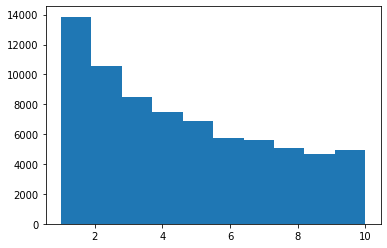

In [28]:
from matplotlib import pyplot as plt
from scipy.io import loadmat

def load_data(path):
    data = loadmat(path)
    return data['X'], data['y']

path = './data/train/train_32x32.mat'
X_train_plot, y_train_plot = load_data(path)
plt.hist(y_train_plot)

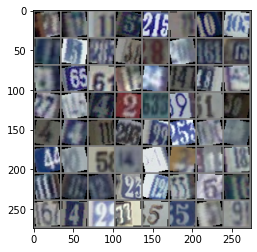

In [22]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 32, 32)
    return x

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# sample a batch and show 
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

## Task 2 : Build a classisfication convolutional neural network


The Model should should have the following achitecture : 
1. 3 Convolution layers : (5 points)
    * conv1 : 2 kernels, 3*3 kernel size, stride 1.
    * conv2 : 4 kernels, 5*5 kernel size, stride 2.
    * conv3 : 8 kernels, 3*3 kernel size, stride 1.
    * Add 1 Avarage pooling layer after 2nd layer and 1 Max-pooling layer before the fully connected layers.
    * Stride for all pooling operations set to 1 
    
    
2. Fully connected layers : 
    * fc1 : 64 output-neurons with a relu activation.
    * output_layer : final layer with no activation function
    * Add Dropout layer after the first (fc1) layer with 25% dropout probability

3. Implement the foward pass method for the CNN  (5 points)
    * Add an activation function of your own choice after every layer
    

In [64]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 2, 3,  stride=1)
        self.conv2 = nn.Conv2d(2, 4, 5,  stride=2)
        self.pool1 = nn.AvgPool2d(2, 1)
        self.conv3 = nn.Conv2d(4, 8, 3,  stride=1)
        self.pool2 = nn.MaxPool2d(2, 1)

        self.fc1 = nn.Linear(8 * 9 * 9, 64)
        self.dropout = nn.Dropout(p=0.25)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(F.relu(self.conv2(x)))
        x = self.pool2(F.relu(self.conv3(x)))
        x = x.view(-1, 8 * 9 * 9)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
        

## Task 3 : Convolutional neural network training precedure (5 points)

Implement the model training procedure and select the appropriate loss function

In [30]:
# Model accuracy calculator 
def accuracy_calc(net,testloader,device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total

In [65]:
model = Net().to(device)
model.parameters

<bound method Module.parameters of Net(
  (conv1): Conv2d(3, 2, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(2, 4, kernel_size=(5, 5), stride=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=1, padding=0)
  (conv3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=648, out_features=64, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)>

In [32]:
#Set hyper parameters 
nb_epoch = 3
lr = 0.001

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss()


def train(model,trainloader, optimizer, criterion, device):
    amount_epochs = nb_epoch
    epoch_loss = 0
    epoch_acc = 0
    for epoch in range(amount_epochs):
      model.train()
      loss_count = 0
      count = 0
      for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(inputs).squeeze(1)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        loss_count += loss.item()
        count+=1

      epoch_acc += accuracy_calc(model, trainloader, device)
      epoch_loss += loss_count / count
    
    return epoch_loss / amount_epochs, epoch_acc / amount_epochs

In [66]:
for epoch in range(nb_epoch):
    epochLoss, epochAcc = train(model,trainloader, optimizer, criterion, device)
    print(f"Epoch : {epoch}, Loss {epochLoss}, Accuracy {epochAcc}")

Epoch : 0, Loss 2.2912879773102475, Accuracy 0.09375213290197525
Epoch : 1, Loss 2.291305400537438, Accuracy 0.09366567927524559
Epoch : 2, Loss 2.291297940708144, Accuracy 0.09468947222335977


## Task 4 (bonus) : Use pretrained CNN model or Viterbi implementation (5 points)

**Option 1** : Import any pretrained model and train on CIFAR10. Print out the loss and accuracy at each an every epoch. Number of training epochs and optimizer are of your choice. <br>
**OPtion 2** : Implement the viterbi algorithm (from previous lab task POS tagging) 

In [ ]:
import torchvision.models as models

transform = transforms.Compose(
    [transforms.Resize((256,256)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = models.resnet18(pretrained=True,progress=True)
        self.net.trainable = False
        self.net.fc = nn.Linear(512, 10)

    def forward(self, x):
        return self.net(x)


net = Net()
net = net.to(device)

In [ ]:
for epoch in range(nb_epoch):
    epochLoss, epochAcc = train(net,trainloader, optimizer, criterion, device)
    print(f"Epoch : {epoch}, Loss {epochLoss}, Accuracy {epochAcc}")